# Hyperparameter Optimization for Stance Classification (OPTUNA)

The goal of this notebook is to optimize the macro F1-score of a stance classification model using hyperparameter optimization (HPO) techniques with Optuna.
We fine-tune our winner model (Best Performance) on a balanced dataset (Previously Augmented) of tweets labeled as support or oppose.

We incorporate:
- Bayesian Optimization (TPE Sampler) to efficiently explore the hyperparameter space.
- Early Stopping to prevent overfitting by stopping training.
- Pruning (Median Pruner) to terminate unpromising trials early and save GPU time.
- Evaluation Metrics: Accuracy, Precision, Recall, and F1-score (macro).

In [1]:
# Libraries
import os
import re
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
import ast
import matplotlib.pyplot as plt
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import warnings
import json
warnings.filterwarnings('ignore')

# Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data from Google Drive: {path}")
else:
    path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data locally from: {path}")


# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU ready:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU detecting, using CPU.")

#If we use the augmented dataset:
augmented = True

# Set Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data locally from: C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining
No GPU detecting, using CPU.


In [2]:
# Load Dataset
if augmented:
  train_path = f"{path}/data/train_augmented_paraphrase.csv"
else:
  train_path = f"{path}/data/train.csv"

dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


# Map labels to ints
label2id = {"oppose": 0, "support": 1}

#Minimal Preprocessing
def clean_tweet(text):

    text = str(text)
    #URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return text


for df in [df_train, df_dev, df_test]:
    #df["tweet_text"] = df["tweet_text"].apply(clean_tweet) Based on our experiment we remove any cleaning to keep the original tweet
    df["label"] = df["stance"].map(label2id)


dataset_train = Dataset.from_pandas(df_train[["tweet_text","label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text","label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text","label"]])

In [3]:
# We define our Model
MODEL_NAME = "roberta-base"
MAX_LEN=105

In [4]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print(f"Tokenizer loaded: {MODEL_NAME}")


# Tokenization Function for each model
def tokenize_dataset(dataset, tokenizer, max_length=MAX_LEN):

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=max_length)

    #Tokenization
    tokenized = dataset.map(tokenize_batch, batched=True)

    #Dataset Format for PyTorch
    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return tokenized

# Tokenize datasets with model tokenizer
train_dataset_tok = tokenize_dataset(dataset_train, tokenizer, MAX_LEN)
dev_dataset_tok = tokenize_dataset(dataset_dev, tokenizer, MAX_LEN)
test_dataset_tok = tokenize_dataset(dataset_test, tokenizer, MAX_LEN)

print(f"Tokenization complete")

Tokenizer loaded: roberta-base


Map: 100%|██████████| 300/300 [00:00<00:00, 2047.40 examples/s]

Tokenization complete


In [5]:
# We define our Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    return {"accuracy": acc,"f1": f1_macro,"precision": precision,"recall": recall}

### Hyperparameter Optimization - OPTUNA

In [6]:
BASELINE_CONFIG = {
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "batch_size": 16,
    "num_train_epochs": 5,
    "warmup_ratio": 0.0,
    "dropout": 0.1}

print("Baseline Config:")
for key, value in BASELINE_CONFIG.items():
    print(f"{key}: {value}")

Baseline Config:
learning_rate: 2e-05
weight_decay: 0.01
batch_size: 16
num_train_epochs: 5
warmup_ratio: 0.0
dropout: 0.1


In [7]:
# We are facing overfitting using only the dev dataset for validation, we are now applying stratification in our train dataset.
train_labels = [ex['label'] for ex in train_dataset_tok]
train_idx, val_idx = train_test_split(range(len(train_dataset_tok)),test_size=0.2,stratify=train_labels,random_state=seed)

#Tokenize
train_subset = train_dataset_tok.select(train_idx)
val_subset = train_dataset_tok.select(val_idx)

print(f"Train subset: {len(train_subset)}, Val subset: {len(val_subset)}")
print(f"Dev set: {len(dev_dataset_tok)}")

Train subset: 1752, Val subset: 438
Dev set: 200


In [ ]:
# Objective Function for Hyperparameter Optimization (OPTUNA) - F1 Score (Macro)
def objective(trial):

    #Hyperparameters to optimize

    # Our search space
    if trial.number > 0:
        learning_rate = trial.suggest_float("learning_rate", 8e-6, 4e-5, log=True)
        weight_decay = trial.suggest_float("weight_decay",0.01, 0.15)
        per_device_train_batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
        num_train_epochs = trial.suggest_int("num_train_epochs", 3, 6)
        warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.15)
        dropout = trial.suggest_float("dropout", 0.1, 0.25)
    else:
        # First trial: Use BASELINE configuration (Performance Benchmark and Data Augmentation notebooks)
        print(f"\n Trial {trial.number}: Using BASELINE configuration")
        learning_rate = BASELINE_CONFIG["learning_rate"]
        weight_decay = BASELINE_CONFIG["weight_decay"]
        per_device_train_batch_size = BASELINE_CONFIG["batch_size"]
        num_train_epochs = BASELINE_CONFIG["num_train_epochs"]
        warmup_ratio = BASELINE_CONFIG["warmup_ratio"]
        dropout = BASELINE_CONFIG["dropout"]


    print(f"\nTrial {trial.number} hyperparameters:")
    print(f"  LR: {learning_rate:.2e}, Batch: {per_device_train_batch_size}, "
          f"Epochs: {num_train_epochs}, WD: {weight_decay:.3f}, "
          f"Warmup: {warmup_ratio:.2f}, Dropout: {dropout:.2f}")

    f1_score = train_single_trial(
        trial=trial,
        train_dataset=train_subset, 
        eval_dataset=val_subset,     
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        warmup_ratio=warmup_ratio,
        dropout=dropout,
        seed=seed
    )

    return f1_score

def train_single_trial(trial, train_dataset, eval_dataset, learning_rate, weight_decay,
                      per_device_train_batch_size, num_train_epochs, warmup_ratio, dropout, seed):


    # Set seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Load Model for this trial
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                               num_labels=2,
                                                               hidden_dropout_prob=dropout,
                                                               attention_probs_dropout_prob=dropout).to(device)

    # Training Arguments
    training_args = TrainingArguments(
        output_dir=f"./optuna-trial-{trial.number}-seed{seed}",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        report_to="none",
        logging_steps=10,
        seed=seed,  # Reproducibility
        data_seed=seed,  # Reproducibility
    )

    # Trainer with Early Stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train
    trainer.train()

    # Final evaluation on dev set
    final_metrics = trainer.evaluate(eval_dataset)
    f1_macro = final_metrics["eval_f1"]

    print(f"  Trial {trial.number} (seed {seed}) - F1: {f1_macro:.4f}")

    # Cleanup to save memory
    del model
    del trainer
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return f1_macro

We use **TPESampler** because it efficiently explores the hyperparameter space by learning from previous trials. Unlike random search, it focuses on promising regions, increasing the chances of finding optimal hyperparameters faster and with fewer trials. It is especially useful for mixed spaces with continuous, integer, and categorical parameters.

In [12]:
print("STARTING HYPERPARAMETER OPTIMIZATION")

study = optuna.create_study(direction="maximize",
                            sampler=TPESampler(seed=seed),
                            pruner=MedianPruner(n_warmup_steps=2, n_startup_trials=3))


trails = 20
study.optimize(objective, n_trials=trails, timeout=None)

[I 2025-11-06 10:54:52,222] A new study created in memory with name: no-name-d032c115-8475-41af-accd-f4a1acf413d4


STARTING HYPERPARAMETER OPTIMIZATION

 Trial 0: Using BASELINE configuration

Trial 0 hyperparameters:
  LR: 2.00e-05, Batch: 16, Epochs: 5, WD: 0.010, Warmup: 0.00, Dropout: 0.10


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.492800,0.274358,0.870000,0.863388,0.857378,0.874339
2,0.260100,0.235041,0.905000,0.892165,0.922899,0.875688
3,0.167400,0.312063,0.880000,0.873297,0.867621,0.882213
4,0.081300,0.308974,0.925000,0.917308,0.928652,0.908910
5,0.051600,0.332712,0.935000,0.929254,0.933516,0.925520


[I 2025-11-06 11:00:32,532] Trial 0 finished with value: 0.9292536257516801 and parameters: {}. Best is trial 0 with value: 0.9292536257516801.


  Trial 0 (seed 42) - F1: 0.9293

Trial 1 hyperparameters:
  LR: 1.83e-05, Batch: 8, Epochs: 3, WD: 0.095, Warmup: 0.01, Dropout: 0.18


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.510400,0.261996,0.890000,0.879121,0.887667,0.872614
2,0.302900,0.358283,0.885000,0.866182,0.916060,0.845378
3,0.241200,0.318014,0.920000,0.912088,0.921333,0.904972


[I 2025-11-06 11:04:31,246] Trial 1 finished with value: 0.9120879120879121 and parameters: {'learning_rate': 1.827226177606625e-05, 'weight_decay': 0.09507143064099162, 'batch_size': 8, 'num_train_epochs': 3, 'warmup_ratio': 0.011616722433639893, 'dropout': 0.1799264218662403}. Best is trial 0 with value: 0.9292536257516801.


  Trial 1 (seed 42) - F1: 0.9121

Trial 2 hyperparameters:
  LR: 2.63e-05, Batch: 16, Epochs: 4, WD: 0.071, Warmup: 0.04, Dropout: 0.08


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.479400,0.392424,0.830000,0.825534,0.824060,0.848668
2,0.254800,0.255030,0.905000,0.892991,0.917857,0.878600
3,0.150400,0.245647,0.920000,0.913709,0.913709,0.913709
4,0.055800,0.281748,0.935000,0.929254,0.933516,0.925520


[I 2025-11-06 11:08:28,733] Trial 2 finished with value: 0.9292536257516801 and parameters: {'learning_rate': 2.631245451057452e-05, 'weight_decay': 0.07080725777960455, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.03636499344142013, 'dropout': 0.07751067647801507}. Best is trial 0 with value: 0.9292536257516801.


  Trial 2 (seed 42) - F1: 0.9293

Trial 3 hyperparameters:
  LR: 1.63e-05, Batch: 32, Epochs: 3, WD: 0.052, Warmup: 0.06, Dropout: 0.10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.608900,0.330068,0.870000,0.857143,0.865223,0.851041
2,0.313500,0.241029,0.885000,0.874038,0.880793,0.868677
3,0.215000,0.239776,0.880000,0.871300,0.869333,0.873476


[I 2025-11-06 11:11:38,388] Trial 3 finished with value: 0.8740381719105124 and parameters: {'learning_rate': 1.6317596956423424e-05, 'weight_decay': 0.052475643163223784, 'batch_size': 32, 'num_train_epochs': 3, 'warmup_ratio': 0.058428929707043636, 'dropout': 0.10495427649405377}. Best is trial 0 with value: 0.9292536257516801.


  Trial 3 (seed 42) - F1: 0.8740

Trial 4 hyperparameters:
  LR: 2.08e-05, Batch: 32, Epochs: 3, WD: 0.079, Warmup: 0.12, Dropout: 0.08


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.565300,0.279384,0.875000,0.856975,0.891369,0.840416
2,0.290600,0.230475,0.875000,0.860238,0.878331,0.849153
3,0.156900,0.247757,0.890000,0.879121,0.887667,0.872614


[I 2025-11-06 11:14:27,451] Trial 4 finished with value: 0.8791208791208791 and parameters: {'learning_rate': 2.083431561152948e-05, 'weight_decay': 0.07851759613930137, 'batch_size': 32, 'num_train_epochs': 3, 'warmup_ratio': 0.12150897038028768, 'dropout': 0.07557861855309374}. Best is trial 0 with value: 0.9292536257516801.


  Trial 4 (seed 42) - F1: 0.8791

Trial 5 hyperparameters:
  LR: 1.11e-05, Batch: 8, Epochs: 3, WD: 0.095, Warmup: 0.14, Dropout: 0.12


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.553200,0.263900,0.875000,0.856975,0.891369,0.840416
2,0.307000,0.274294,0.905000,0.892991,0.917857,0.878600
3,0.224500,0.302783,0.925000,0.917308,0.928652,0.908910


[I 2025-11-06 11:17:32,519] Trial 5 finished with value: 0.9173075332837178 and parameters: {'learning_rate': 1.1103735608516824e-05, 'weight_decay': 0.09488855372533334, 'batch_size': 8, 'num_train_epochs': 3, 'warmup_ratio': 0.1368466053024314, 'dropout': 0.11602287406094021}. Best is trial 0 with value: 0.9292536257516801.


  Trial 5 (seed 42) - F1: 0.9173

Trial 6 hyperparameters:
  LR: 1.22e-05, Batch: 16, Epochs: 6, WD: 0.050, Warmup: 0.06, Dropout: 0.13


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.605000,0.370957,0.840000,0.832618,0.827110,0.844893
2,0.315100,0.203146,0.895000,0.887698,0.884762,0.891112
3,0.215300,0.290901,0.885000,0.880454,0.874188,0.897800
4,0.140100,0.298409,0.895000,0.888295,0.883880,0.894024
5,0.107300,0.301319,0.925000,0.917308,0.928652,0.908910
6,0.059400,0.280565,0.935000,0.929254,0.933516,0.925520


[I 2025-11-06 11:23:51,766] Trial 6 finished with value: 0.9292536257516801 and parameters: {'learning_rate': 1.2170293883738781e-05, 'weight_decay': 0.04951769101112702, 'batch_size': 16, 'num_train_epochs': 6, 'warmup_ratio': 0.06234221521788219, 'dropout': 0.12801020317667164}. Best is trial 0 with value: 0.9292536257516801.


  Trial 6 (seed 42) - F1: 0.9293

Trial 7 hyperparameters:
  LR: 2.41e-05, Batch: 8, Epochs: 7, WD: 0.018, Warmup: 0.12, Dropout: 0.19


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.617100,0.375405,0.865000,0.841507,0.896667,0.820893
2,0.388900,0.277849,0.885000,0.873205,0.883424,0.865764
3,0.293200,0.406401,0.885000,0.874833,0.878571,0.871589
4,0.224100,0.402949,0.910000,0.899001,0.921453,0.885449
5,0.155800,0.379382,0.905000,0.895945,0.903075,0.890249
6,0.096300,0.463627,0.925000,0.920616,0.914583,0.929296
7,0.060900,0.478380,0.915000,0.908046,0.909288,0.906860


[I 2025-11-06 11:32:05,336] Trial 7 finished with value: 0.9206160196872271 and parameters: {'learning_rate': 2.4106495902171624e-05, 'weight_decay': 0.018485445552552705, 'batch_size': 8, 'num_train_epochs': 7, 'warmup_ratio': 0.11957999576221703, 'dropout': 0.18828113525346757}. Best is trial 0 with value: 0.9292536257516801.


  Trial 7 (seed 42) - F1: 0.9206

Trial 8 hyperparameters:
  LR: 1.15e-05, Batch: 32, Epochs: 4, WD: 0.020, Warmup: 0.17, Dropout: 0.10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.677100,0.458611,0.825000,0.801356,0.825765,0.789397
2,0.387000,0.272557,0.880000,0.869792,0.872148,0.867652
3,0.255800,0.229671,0.905000,0.895945,0.903075,0.890249
4,0.193600,0.218026,0.910000,0.900431,0.913390,0.891274


[I 2025-11-06 11:35:48,567] Trial 8 finished with value: 0.9004314636574842 and parameters: {'learning_rate': 1.1530645080977555e-05, 'weight_decay': 0.019598286241914523, 'batch_size': 32, 'num_train_epochs': 4, 'warmup_ratio': 0.1657475018303859, 'dropout': 0.1035129990040384}. Best is trial 0 with value: 0.9292536257516801.


  Trial 8 (seed 42) - F1: 0.9004

Trial 9 hyperparameters:
  LR: 1.57e-05, Batch: 16, Epochs: 7, WD: 0.054, Warmup: 0.15, Dropout: 0.08


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.647900,0.378244,0.845000,0.835940,0.831250,0.843005
2,0.323300,0.302844,0.885000,0.864988,0.923333,0.842466
3,0.213500,0.388671,0.880000,0.875000,0.868681,0.890950
4,0.090300,0.406195,0.910000,0.899001,0.921453,0.885449
5,0.049400,0.343328,0.930000,0.924045,0.926739,0.921583
6,0.024700,0.378483,0.920000,0.914200,0.912000,0.916622
7,0.017400,0.377830,0.935000,0.930091,0.928893,0.931345


[I 2025-11-06 11:43:00,338] Trial 9 finished with value: 0.930090613320427 and parameters: {'learning_rate': 1.5716824201651505e-05, 'weight_decay': 0.05426960831582485, 'batch_size': 16, 'num_train_epochs': 7, 'warmup_ratio': 0.1544489538593315, 'dropout': 0.07980735223012586}. Best is trial 9 with value: 0.930090613320427.


  Trial 9 (seed 42) - F1: 0.9301

Trial 10 hyperparameters:
  LR: 4.58e-05, Batch: 16, Epochs: 7, WD: 0.001, Warmup: 0.20, Dropout: 0.06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.553900,0.395129,0.795000,0.792253,0.800881,0.824021
2,0.325200,0.301858,0.875000,0.856975,0.891369,0.840416
3,0.176500,0.299859,0.890000,0.878305,0.890598,0.869701
4,0.081400,0.448381,0.905000,0.894535,0.909467,0.884425
5,0.034200,0.307154,0.935000,0.931201,0.925000,0.940082
6,0.012600,0.410043,0.920000,0.914200,0.912000,0.916622
7,0.003600,0.435043,0.905000,0.895256,0.906038,0.887337


[I 2025-11-06 11:50:15,216] Trial 10 finished with value: 0.9312005503955968 and parameters: {'learning_rate': 4.577434034785655e-05, 'weight_decay': 0.000599718295581711, 'batch_size': 16, 'num_train_epochs': 7, 'warmup_ratio': 0.1958570774988351, 'dropout': 0.05580877999417745}. Best is trial 10 with value: 0.9312005503955968.


  Trial 10 (seed 42) - F1: 0.9312

Trial 11 hyperparameters:
  LR: 4.82e-05, Batch: 16, Epochs: 7, WD: 0.004, Warmup: 0.20, Dropout: 0.05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.561300,0.453154,0.775000,0.772951,0.787641,0.808273
2,0.276900,0.233959,0.905000,0.899447,0.893750,0.907723
3,0.168600,0.462399,0.910000,0.899733,0.917159,0.888362
4,0.071100,0.398071,0.910000,0.899733,0.917159,0.888362
5,0.040900,0.602292,0.890000,0.884925,0.878261,0.898824


[I 2025-11-06 11:55:50,074] Trial 11 finished with value: 0.8997326203208555 and parameters: {'learning_rate': 4.823815513416646e-05, 'weight_decay': 0.004149266874993421, 'batch_size': 16, 'num_train_epochs': 7, 'warmup_ratio': 0.19914770556864808, 'dropout': 0.051501907425185504}. Best is trial 10 with value: 0.9312005503955968.


  Trial 11 (seed 42) - F1: 0.8997

Trial 12 hyperparameters:
  LR: 4.63e-05, Batch: 16, Epochs: 6, WD: 0.043, Warmup: 0.20, Dropout: 0.05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.558200,0.374462,0.820000,0.816401,0.818682,0.843706
2,0.301800,0.238918,0.910000,0.899733,0.917159,0.888362
3,0.174800,0.327317,0.910000,0.899733,0.917159,0.888362
4,0.072800,0.395235,0.895000,0.882600,0.901706,0.870726


[I 2025-11-06 11:59:41,212] Trial 12 finished with value: 0.8997326203208555 and parameters: {'learning_rate': 4.63480588396658e-05, 'weight_decay': 0.043435627175641124, 'batch_size': 16, 'num_train_epochs': 6, 'warmup_ratio': 0.1989847209854932, 'dropout': 0.05069848879271735}. Best is trial 10 with value: 0.9312005503955968.


  Trial 12 (seed 42) - F1: 0.8997

Trial 13 hyperparameters:
  LR: 3.35e-05, Batch: 16, Epochs: 6, WD: 0.031, Warmup: 0.16, Dropout: 0.08


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.564100,0.398788,0.815000,0.812063,0.817827,0.842681
2,0.288600,0.256940,0.905000,0.890398,0.934932,0.869863
3,0.152100,0.397958,0.890000,0.882025,0.880000,0.884263
4,0.052000,0.490113,0.885000,0.874833,0.878571,0.871589


[I 2025-11-06 12:04:27,176] Trial 13 finished with value: 0.890398315595166 and parameters: {'learning_rate': 3.3466886044300824e-05, 'weight_decay': 0.030726431270949577, 'batch_size': 16, 'num_train_epochs': 6, 'warmup_ratio': 0.15768568609433326, 'dropout': 0.07727323589883128}. Best is trial 10 with value: 0.9312005503955968.


  Trial 13 (seed 42) - F1: 0.8904

Trial 14 hyperparameters:
  LR: 3.37e-05, Batch: 16, Epochs: 7, WD: 0.062, Warmup: 0.17, Dropout: 0.15


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.624000,0.321422,0.880000,0.869792,0.872148,0.867652
2,0.353200,0.277118,0.880000,0.859748,0.913015,0.838529
3,0.224600,0.255975,0.910000,0.904000,0.900116,0.908748
4,0.141800,0.352507,0.920000,0.911495,0.924786,0.902060
5,0.090500,0.346308,0.930000,0.925333,0.921233,0.930320
6,0.031300,0.461173,0.905000,0.895945,0.903075,0.890249
7,0.028200,0.432895,0.920000,0.913194,0.915821,0.910797


[I 2025-11-06 12:11:44,736] Trial 14 finished with value: 0.9253333333333333 and parameters: {'learning_rate': 3.3697839272973526e-05, 'weight_decay': 0.06206638073283165, 'batch_size': 16, 'num_train_epochs': 7, 'warmup_ratio': 0.16939922467773308, 'dropout': 0.149128358793843}. Best is trial 10 with value: 0.9312005503955968.


  Trial 14 (seed 42) - F1: 0.9253

Trial 15 hyperparameters:
  LR: 1.53e-05, Batch: 16, Epochs: 5, WD: 0.000, Warmup: 0.10, Dropout: 0.09


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.560200,0.318949,0.860000,0.852879,0.847081,0.863553
2,0.285100,0.219339,0.900000,0.889368,0.901994,0.880488
3,0.183200,0.238020,0.905000,0.899934,0.893448,0.910635
4,0.083000,0.312213,0.930000,0.922014,0.940331,0.909934
5,0.053300,0.326287,0.930000,0.923572,0.929417,0.918671


[I 2025-11-06 12:17:30,348] Trial 15 finished with value: 0.9235724424063763 and parameters: {'learning_rate': 1.531304736577359e-05, 'weight_decay': 0.0004520993701316369, 'batch_size': 16, 'num_train_epochs': 5, 'warmup_ratio': 0.09573876952626573, 'dropout': 0.08713809027183114}. Best is trial 10 with value: 0.9312005503955968.


  Trial 15 (seed 42) - F1: 0.9236

Trial 16 hyperparameters:
  LR: 3.17e-05, Batch: 16, Epochs: 6, WD: 0.039, Warmup: 0.18, Dropout: 0.06


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.549200,0.356845,0.845000,0.812751,0.892483,0.790584
2,0.272700,0.356192,0.885000,0.869463,0.898616,0.854115
3,0.180800,0.306791,0.895000,0.889401,0.883113,0.899849
4,0.065000,0.367359,0.910000,0.902344,0.904902,0.900011
5,0.031000,0.364070,0.915000,0.908046,0.909288,0.906860
6,0.006500,0.390649,0.925000,0.918864,0.920139,0.917646


[I 2025-11-06 12:23:55,726] Trial 16 finished with value: 0.9188640973630832 and parameters: {'learning_rate': 3.167837034374341e-05, 'weight_decay': 0.03873122289887643, 'batch_size': 16, 'num_train_epochs': 6, 'warmup_ratio': 0.1755766063174529, 'dropout': 0.06301532744864954}. Best is trial 10 with value: 0.9312005503955968.


  Trial 16 (seed 42) - F1: 0.9189

Trial 17 hyperparameters:
  LR: 3.95e-05, Batch: 16, Epochs: 7, WD: 0.028, Warmup: 0.15, Dropout: 0.09


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.573400,0.395636,0.870000,0.864003,0.857801,0.877252
2,0.332900,0.222245,0.905000,0.892165,0.922899,0.875688
3,0.165100,0.359301,0.880000,0.871300,0.869333,0.873476
4,0.093800,0.453045,0.895000,0.889911,0.883210,0.902761


[I 2025-11-06 12:28:48,288] Trial 17 finished with value: 0.8921649309004228 and parameters: {'learning_rate': 3.945749022058405e-05, 'weight_decay': 0.028233922852888095, 'batch_size': 16, 'num_train_epochs': 7, 'warmup_ratio': 0.14864919675272203, 'dropout': 0.09318639491975964}. Best is trial 10 with value: 0.9312005503955968.


  Trial 17 (seed 42) - F1: 0.8922

Trial 18 hyperparameters:
  LR: 1.39e-05, Batch: 16, Epochs: 5, WD: 0.062, Warmup: 0.18, Dropout: 0.14


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.667900,0.366362,0.825000,0.802878,0.822619,0.792309
2,0.370900,0.232964,0.905000,0.895945,0.903075,0.890249
3,0.229900,0.281578,0.890000,0.884925,0.878261,0.898824
4,0.150500,0.225917,0.900000,0.893888,0.888796,0.900874


[I 2025-11-06 12:33:08,945] Trial 18 finished with value: 0.8959445767956407 and parameters: {'learning_rate': 1.3944516690011926e-05, 'weight_decay': 0.06196482590568278, 'batch_size': 16, 'num_train_epochs': 5, 'warmup_ratio': 0.18426931080288114, 'dropout': 0.1399252757385379}. Best is trial 10 with value: 0.9312005503955968.


  Trial 18 (seed 42) - F1: 0.8959

Trial 19 hyperparameters:
  LR: 2.00e-05, Batch: 8, Epochs: 7, WD: 0.081, Warmup: 0.10, Dropout: 0.07


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.532000,0.295901,0.885000,0.869463,0.898616,0.854115
2,0.305200,0.372955,0.910000,0.897436,0.931788,0.879625
3,0.166100,0.378677,0.915000,0.904962,0.925082,0.892299
4,0.067200,0.453938,0.900000,0.891493,0.893984,0.889224
5,0.024400,0.600838,0.900000,0.892137,0.892137,0.892137


[I 2025-11-06 12:39:09,192] Trial 19 finished with value: 0.9049615653389238 and parameters: {'learning_rate': 2.0026528870528834e-05, 'weight_decay': 0.08148895617554172, 'batch_size': 8, 'num_train_epochs': 7, 'warmup_ratio': 0.09556514800778138, 'dropout': 0.065025020770085}. Best is trial 10 with value: 0.9312005503955968.


  Trial 19 (seed 42) - F1: 0.9050


### Optimization Results

In [13]:
print("Optimization completed.")
print("\n BEST TRIAL:")
print(f"  Trial number: {study.best_trial.number}")
print(f"  F1 Score: {study.best_trial.value:.4f}")
print("\n  Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

# Compare with baseline
baseline_trial = study.trials[0]
print(f"\n BASELINE PERFORMANCE (Trial 0):")
print(f"  F1 Score: {baseline_trial.value:.4f}")
improvement = study.best_trial.value - baseline_trial.value
print(f"\n Improvement over baseline: {improvement:+.4f} ({improvement/baseline_trial.value*100:+.2f}%)")

Optimization completed.

 BEST TRAIL:

 BEST TRIAL:
  Trial number: 10
  F1 Score: 0.9312

  Best hyperparameters:
    learning_rate: 4.577434034785655e-05
    weight_decay: 0.000599718295581711
    batch_size: 16
    num_train_epochs: 7
    warmup_ratio: 0.1958570774988351
    dropout: 0.05580877999417745

 BASELINE PERFORMANCE (Trial 0):
  F1 Score: 0.9293

 Improvement over baseline: +0.0019 (+0.21%)


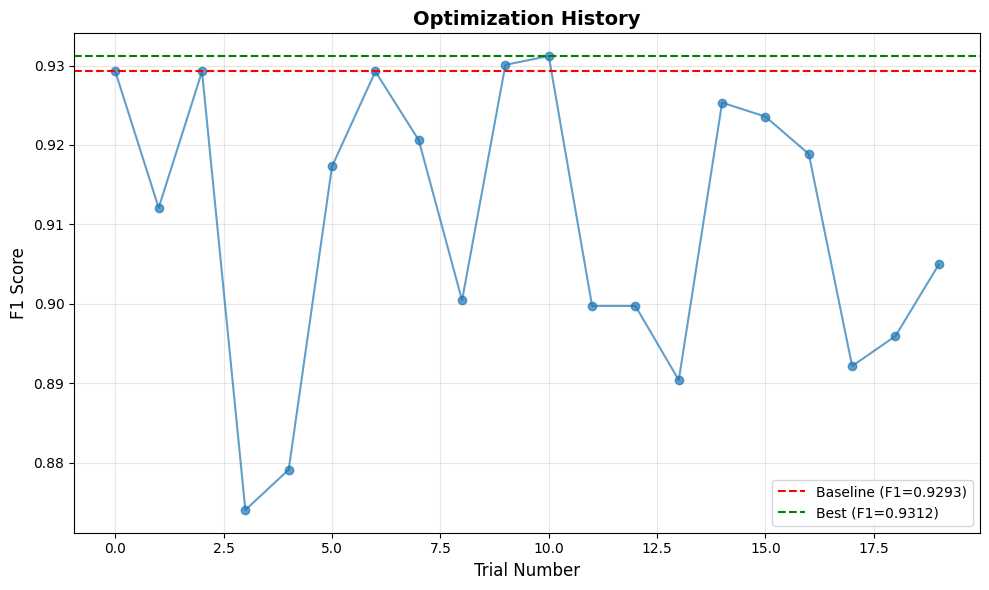

In [14]:
# Visualization Optimization History plot
fig = plt.figure(figsize=(10, 6))
# Plot 1: Optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]

plt.plot(trial_numbers, trial_values, 'o-', alpha=0.7)
plt.axhline(y=baseline_trial.value, color='r', linestyle='--',
              label=f'Baseline (F1={baseline_trial.value:.4f})')
plt.axhline(y=study.best_trial.value, color='g', linestyle='--',
              label=f'Best (F1={study.best_trial.value:.4f})')
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Optimization History', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# We retrain the model with the best hyperparameters

best_params = study.best_trial.params
print("\nRetraining best model with optimal hyperparameters...")
print("\nHyperparameters used: ")
for key, value in best_params.items():
    print(f"    {key}: {value}")


best_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2,
                                                                hidden_dropout_prob=best_params["dropout"],
                                                                attention_probs_dropout_prob=best_params["dropout"]).to(device)

best_args = TrainingArguments(
    output_dir="./roberta_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_ratio=best_params["warmup_ratio"],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none",
    seed=seed
)

final_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset_tok, #We use the whole train dataset, not the stratified
    eval_dataset=dev_dataset_tok, #Dev for early stopping
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

final_trainer.train()

eval_results = final_trainer.evaluate(test_dataset_tok)
print("\nFinal evaluation on test set:", eval_results)


Retraining best model with optimal hyperparameters...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.540200,0.295917,0.870000,0.850643,0.887774,0.833567
2,0.311300,0.323011,0.890000,0.874644,0.907251,0.858052
3,0.191100,0.287527,0.910000,0.901099,0.910111,0.894186
4,0.088000,0.599810,0.895000,0.879859,0.916171,0.861989
5,0.048000,0.391023,0.935000,0.930091,0.928893,0.931345
6,0.013700,0.497974,0.910000,0.902344,0.904902,0.900011
7,0.003800,0.499142,0.920000,0.912654,0.918354,0.907885



Final evaluation on test set: {'eval_loss': 1.2901135683059692, 'eval_accuracy': 0.8, 'eval_f1': 0.7992773986350863, 'eval_precision': 0.8126793400286945, 'eval_recall': 0.8247345874464519, 'eval_runtime': 1.9511, 'eval_samples_per_second': 153.76, 'eval_steps_per_second': 9.738, 'epoch': 7.0}


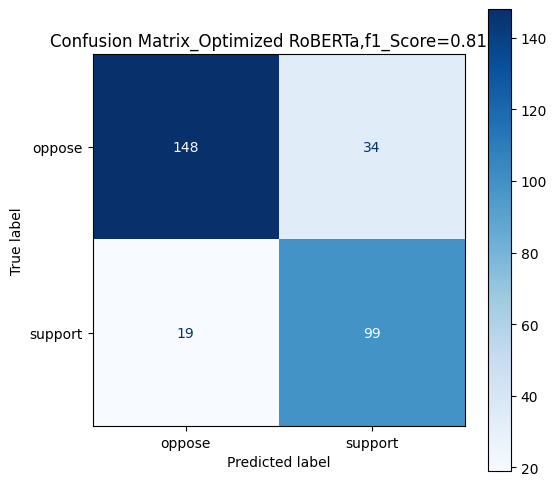

In [17]:
# Path Output
os.makedirs(f"{path}/experiments/text/HPO/", exist_ok=True)
output_dir = f"{path}/experiments/text/HPO/"

# Confusion Matrix
preds_output = final_trainer.predict(test_dataset_tok)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["oppose", "support"])

# Export
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title(f"Confusion Matrix_Optimized RoBERTa,f1_Score={eval_results['eval_f1']:.4f}")
save_path = os.path.join(output_dir,f"confusion_matrix_Model_Optimized.jpg")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()



In [20]:
# Export metrics to CSV
results_df = pd.DataFrame(eval_results).rename(columns={
    "eval_accuracy": "accuracy",
    "eval_f1": "f1",
    "eval_precision": "precision",
    "eval_recall": "recall"
})
results_df = results_df[["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]]
results_df.to_csv(output_dir + "evaluation_results.csv", index=False)
print(f"Metrics saved to {output_dir}/evaluation_results.csv")
print(results_df)

ValueError: If using all scalar values, you must pass an index

In [ ]:
# Export best hyperparameters to JSON
best_hyperparams = study.best_trial.params
with open(f"{output_dir}/best_hyperparameters.json", "w") as f:
    json.dump(best_hyperparams, f, indent=4)
print(f"Best hyperparameters saved to {output_dir}/best_hyperparameters.json")
print(best_hyperparams)